### Import Libraries

In [8]:
import sys

sys.path.append('..')

In [9]:
import utils.data
import utils.trans
import utils.extract
import utils.visualize
import utils.features
import utils.models
import utils.models_utils

In [10]:
from importlib import reload

In [11]:
reload(utils.data)
reload(utils.trans)
reload(utils.extract)
reload(utils.visualize)
reload(utils.features)
reload(utils.models)
reload(utils.models_utils)

<module 'utils.models_utils' from '..\\utils\\models_utils.py'>

### Train Model

In [12]:
import numpy as np

In [13]:
import keras
from keras.layers import *
from keras.engine import Model
from keras.optimizers import SGD

In [14]:
from utils.models_utils import conv_block_2d

In [15]:
x_data_final = np.random.random((1000, 512, 128, 3))
x_shape = x_data_final.shape[1:]

print(x_data_final.shape)
print(x_shape)

(1000, 512, 128, 3)
(512, 128, 3)


In [16]:
# split data:

n_data = x_data_final.shape[0]
part_train = 0.8
n_train = int(part_train*n_data)

x_train = x_data_final[:n_train]
x_val = x_data_final[n_train:]

print(x_shape)
print(x_train.shape)
print(x_val.shape)

(512, 128, 3)
(800, 512, 128, 3)
(200, 512, 128, 3)


In [17]:
def spectrum_autoencoder(x_shape, dropout=0.1):
    # model: raw-spec to raw-spec
    
    inputs = Input(x_shape)
    x = inputs
    
    n_filters = 16
    
    # Encoder
    x = conv_block_2d(inputs,
                      filters=n_filters, kernel_size=(3,3), padding='same', 
                      do_batch_norm=True, activation='relu', pool_size=(2,2), dropout=dropout)
 
    x = conv_block_2d(x,
                      filters=n_filters, kernel_size=(8,3), padding='same', 
                      do_batch_norm=True, activation='relu', pool_size=(2,2), dropout=dropout)
    
    large_filter = 32
    
    x = conv_block_2d(x,
                      filters=n_filters, kernel_size=(large_filter,3), padding='same', 
                      do_batch_norm=True, activation='relu', pool_size=(2,2), dropout=dropout)
    
    encoded = x
    
    # Decoder
    x = Conv2D(filters=n_filters, kernel_size=(large_filter,3), padding='same', activation='relu')(encoded)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)
    
#     n_channels = 1
    n_channels = 3
    
    outputs = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same', activation='relu')(x)
    
    outputs = Reshape(x_shape)(outputs)

    model = Model(inputs, outputs)
    encoder = Model(inputs, encoded)
#     decoder = Model(encoded, outputs)
    decoder = None
    
    return model, encoder, decoder

In [24]:
learn_rate = 0.01
momentum = 0.0
dropout = 0.1
batch_size = 100
epochs = 5

model, encoder, decoder = spectrum_autoencoder(x_shape, dropout=dropout)
optimizer = SGD(lr=learn_rate, momentum=momentum)
model.compile(optimizer=optimizer, loss='mse')

In [25]:
# model.summary()

In [26]:
plot_losses = utils.models_utils.PlotLosses()

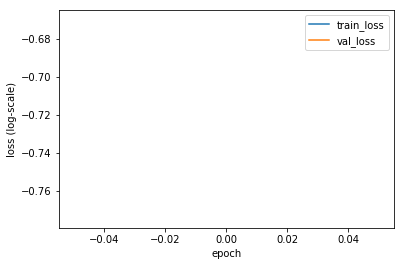

Epoch 2/5
100/800 [==>...........................] - ETA: 2:42 - loss: 0.1827

KeyboardInterrupt: 

In [27]:
history = model.fit(
    x=x_train,
    y=x_train,
    batch_size=batch_size,
    epochs=epochs, 
    validation_data=(x_val, x_val),
    callbacks=[plot_losses],
)